In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Валидация модели на инференсе

Считаем, что меток через некоторое время не приходит. Так как разметка в CV не проста и дорога

Необходимо мониторить два основных аспекта:
1. Качество самой модели (возможно переобучение, деградация или просто аномальность работы)
2. Качество входящих данных

Одно от другого зависит, и, скорее, если данные не изменились, то и модель будет нормально работать (если она автоматически не дообучается, в случае наличия меток).

От нескольких людей уже слышал, что на проде ограничиваются простым подсчетом статистик (но это классический ML, там и метки иногда есть).

# Качество модели

### Начнем агрегировать статистики по предсказанным классам и вероятностям. Если в них наблюдается слишком много выбросов относительно валидации и меняется распределение уверенности модели - возможный сигнал о деградации модели (или сдвиге в данных) 

In [1]:
!git clone https://github.com/ultralytics/yolov5 --quiet
!pip install -r ./yolov5/requirements.txt --quiet

     |████████████████████████████████| 636 kB 8.2 MB/s 


In [2]:
%cd yolov5

/content/yolov5


In [30]:
import glob
import cv2
import numpy as np
from scipy.stats import ks_2samp

import torch
from utils.general import non_max_suppression, apply_classifier
import models

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [31]:
val = glob.glob('/content/drive/MyDrive/DataSet_fishes/valid/images/*')
train = glob.glob('/content/drive/MyDrive/DataSet_fishes/train/images/*')

ext_data = glob.glob('/content/drive/MyDrive/DataSet_fishes/coco_val2017_part/*jpg')

print(len(train), len(val), len(ext_data))

train = train[:125]
ext_norm = val[:125]
ext_out = ext_data[:125]

448 127 510


In [135]:
def get_images(paths):
  images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in paths]
  images = [cv2.resize(img, (640, 640)) for img in images]
  images = np.array(images)

  return images

In [136]:
images = get_images(val[:125])
images_fake = get_images(ext_data[:125])

In [140]:
device = torch.device("cuda:0")

ckpt = torch.load('/content/drive/MyDrive/DataSet_fishes/yolov5s_base.pt', device) 
model = ckpt['model']

In [141]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [142]:
def easy_infer(
  images,
  augment=False,
  half = True,
  stride = int(model.stride.max()),  # model stride
  classes=None,  # filter by class: --class 0, or --class 0 2 3
  agnostic_nms=False,
  iou_thres=0.45,
  conf_thres=0.25,
  max_det=1000,
):

  # Run inference
  if device.type != 'cpu':
      model(torch.zeros(1, 3, 640, 640).to(device).type_as(next(model.parameters())))  # run once
  t0 = time.time()

  all_preds = np.array([])

  for img0 in images:
    # Padded resize
    img = letterbox(img0, (640, 640), stride=stride)[0]

    # Convert
    img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img = np.ascontiguousarray(img)
    
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img,
                augment=augment,
                visualize=False)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, None, agnostic_nms, max_det=max_det)[0]
    pred = pred.cpu().detach().numpy()

    if len(all_preds) == 0:
      all_preds = pred
    else:
      all_preds = np.concatenate([all_preds, pred])

  return all_preds


In [145]:
all_preds = easy_infer(images)
all_preds_fake = easy_infer(images_fake)

In [147]:
all_preds.shape, all_preds_fake.shape

((1078, 6), (501, 6))

In [150]:
conf, classes = all_preds[:, 4], all_preds[:, 5]
conf_fake, classes_fake = all_preds_fake[:, 4], all_preds_fake[:, 5]

### Как видим, распределение вероятности сильно смещается в сторону меньших значений.<br> Так что имеет смысл либо смотреть на среднее значение вероятноти, либо на некоторый квантиль.

### Или можно просто посчитать статистический тест на равенство распределений

#### Заметим, что само распределение классов сильно не изменилось

Ks_2sampResult(statistic=0.33466462251748824, pvalue=7.771561172376096e-16)

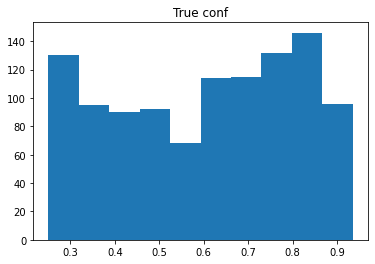

Mean value: 0.6034913659095764


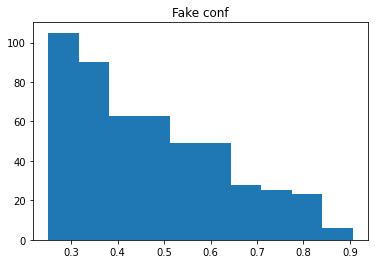

Mean value: 0.4687533974647522


In [175]:
# if pvalue < 0.05 -> что-то с сетью или пришли новые данные
display(ks_2samp(conf_fake, conf))

plt.hist(conf, 10)
plt.title('True conf')
plt.show()
print(f'Mean value: {conf.mean()}')

plt.hist(conf_fake, 10)
plt.title('Fake conf')
plt.show()
print(f'Mean value: {conf_fake.mean()}')

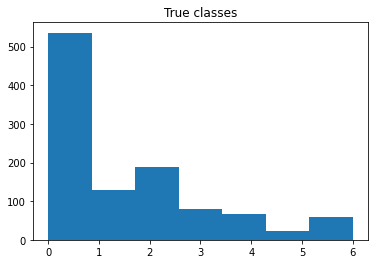

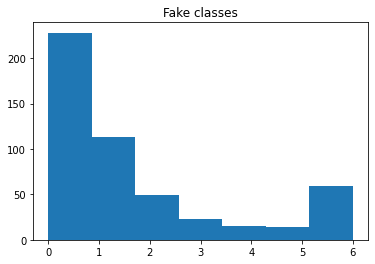

In [171]:
plt.hist(classes, 7)
plt.title('True classes')
plt.show()

plt.hist(classes_fake, 7)
plt.title('Fake classes')
plt.show()

# Качество данных

### Обучим простую сеть, которая будет пытаться отделить валидационную выборку от пришедших за день данных. Если у нее получается, то это сигнализирует о смещении в данных <br>(реализация на keras для демонстрации простоты/вариативности)

Вариантов модели очень много:
1. Простая сеть классификатор на простой основе (здесь используется). Если точность > 0.7 => возможно пришли новые данные
2. Простая сеть енкодер-декодер. Мониторинг количества выбросов по тесту 3 sigma на ошибке восстановления
3. Isolation forest/бустинг (в зависимости от подхода) над выходами из последних слоев
4. Isolation forest/бустинг (в зависимости от подхода) над HOG признаками

Первый вариант самый простой. Скорее всего, что-то сложнее не будет использоваться

## Результат
1. данные одного вида - accuracy ~0.5
2. Данные разных видов - accuracy ~0.9

Можно взять порог, при котором приходит уведомление - 0.7

### Ps.: реализация на keras, только чтобы показать вариативность. Вообще так в проде лучше стараться не делать (yolo-v5 на torch)

In [ ]:
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras import  Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import glob

In [ ]:
!ls drive/MyDrive/DataSet_fishes

coco_val2017_part    test		       valid		yolov5s_base.pt
README.dataset.txt   train		       yolov5m_base.pt
README.roboflow.txt  train_freeze_backbone.py  yolov5s_base


In [ ]:
val = glob.glob('drive/MyDrive/DataSet_fishes/valid/images/*')
train = glob.glob('drive/MyDrive/DataSet_fishes/train/images/*')

ext_data = glob.glob('drive/MyDrive/DataSet_fishes/coco_val2017_part/*jpg')

print(len(train), len(val), len(ext_data))

train = train[:125]
ext_norm = val[:125]
ext_out = ext_data[:125]

448 127 510


In [ ]:
X_train_fake = train[:100] + ext_out[:100]
X_train = train[:100] + ext_norm[:100]
y_train = [0]*100 + [1]*100

X_val_fake = train[100:] + ext_out[100:]
X_val = train[100:] + ext_norm[100:]
y_val = [0]*25 + [1]*25

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.1),
        preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.15),
        preprocessing.RandomFlip(mode="horizontal"),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomZoom(0.2),
    ],
    name="img_augmentation",
)

In [ ]:
class DataGen(tf.keras.utils.Sequence):
    
    def __init__(self, train_paths, y_train,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True
                 ):
        
      self.train_paths = np.array(train_paths)
      self.y_train = np.array(y_train)
      self.batch_size = batch_size
      self.input_size = input_size
      self.shuffle = shuffle
      
      self.n = len(self.train_paths)
    
    @staticmethod
    def _unison_shuffled_copies(a, b):
      assert len(a) == len(b)
      p = np.random.permutation(len(a))
      
      return a[p], b[p]

    def on_epoch_end(self):
        self.train_paths, self.y_train = DataGen._unison_shuffled_copies(self.train_paths, self.y_train)
    
    def __getitem__(self, index):
        path = self.train_paths[index]

        start = index * self.batch_size
        finish = (index+1) * self.batch_size

        images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in self.train_paths[start:finish]]
        images = [cv2.resize(img, self.input_size[:2]) for img in images]
        images = np.array(images)
        labels = self.y_train[start:finish]

        return images, np.array(labels)
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
IMG_SIZE = (224, 224, 3)

In [ ]:
datagen_train = DataGen(X_train, y_train, 8, IMG_SIZE)
datagen_train_fake = DataGen(X_train_fake, y_train, 8, IMG_SIZE)

datagen_val = DataGen(X_val, y_val, 8, IMG_SIZE)
datagen_val_fake = DataGen(X_val_fake, y_val, 8, IMG_SIZE)

In [ ]:

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = img_augmentation(inputs)

model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=x)
model.trainable = False

x = model(x)
x = layers.Flatten()(x)

x = layers.Dense(200, activation="relu", name="dense")(x)
x = layers.Dense(50, activation="relu", name="dense2")(x)
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

model = tf.keras.Model(inputs, outputs, name="Xception")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
flatten_6 (Flatten)          (None, 75264)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               15053000  
_________________________________________________________________
dense2 (Dense)               (None, 50)                10050     
_________________________________________________________________
pred (Dense)                 (None, 1)                 51 

In [ ]:
callbacks = [
      #keras.callbacks.ModelCheckpoint("online_metric_model.h5", save_best_only=True),
  ]

## Модель не может отделить "валидационную" и "новую" выборки, <br> что выливается в accuracy ~0.5

In [ ]:
epochs = 10  # @param {type: "slider", min:8, max:300}
hist = model.fit(datagen_train, epochs=epochs, 
                 callbacks=callbacks, validation_data=datagen_val, 
                 verbose=1)  

Epoch 1/10
25/25 [==============================] - 16s 675ms/step - loss: 0.7050 - accuracy: 0.3400 - val_loss: 0.6937 - val_accuracy: 0.4792
Epoch 2/10
25/25 [==============================] - 6s 257ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 5s 205ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 4/10
25/25 [==============================] - 5s 204ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4792
Epoch 5/10
25/25 [==============================] - 5s 204ms/step - loss: 0.6936 - accuracy: 0.4600 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
25/25 [==============================] - 5s 206ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
25/25 [==============================] - 5s 207ms/step - loss: 0.6935 - accuracy: 0.4200 - val_loss: 0.6932 - val_accuracy: 0.4792
Epoch

## Модель легко отделяет "валидационную" и "новую" выборки, <br> что выливается в accuracy ~0.9
### На проде врятли такая сильная разница будет, поэтому имеет смысл брать порог около ~0.6-0.7

In [ ]:
epochs = 10  # @param {type: "slider", min:8, max:300}
hist2 = model.fit(datagen_train_fake, epochs=epochs, 
                 callbacks=callbacks, validation_data=datagen_val_fake, 
                 verbose=1)  

Epoch 1/10
25/25 [==============================] - 19s 290ms/step - loss: 7.2709 - accuracy: 0.7700 - val_loss: 2.5955 - val_accuracy: 0.8333
Epoch 2/10
25/25 [==============================] - 4s 178ms/step - loss: 0.9985 - accuracy: 0.8900 - val_loss: 2.5257 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 4s 177ms/step - loss: 0.8964 - accuracy: 0.8600 - val_loss: 0.2817 - val_accuracy: 0.8958
Epoch 4/10
25/25 [==============================] - 4s 177ms/step - loss: 0.3401 - accuracy: 0.9350 - val_loss: 1.3038 - val_accuracy: 0.8333
Epoch 5/10
25/25 [==============================] - 4s 177ms/step - loss: 0.8119 - accuracy: 0.8700 - val_loss: 0.7386 - val_accuracy: 0.9167
Epoch 6/10
25/25 [==============================] - 4s 175ms/step - loss: 0.4828 - accuracy: 0.9350 - val_loss: 0.3559 - val_accuracy: 0.9167
Epoch 7/10
25/25 [==============================] - 5s 180ms/step - loss: 0.6392 - accuracy: 0.9350 - val_loss: 0.3308 - val_accuracy: 0.8750
Epoch